In [1]:
import os
import shutil
import random

# === CONFIGURATION ===
SOURCE_DIR = r"/kaggle/input/full-dataset-20person/NEW_DataSet_20_person"  # Your dataset path
DEST_ROOT = "./kfold_dataset_10"
CLASS_MAP = {
    "Left_eye": "left",
    "Right_eye": "right",
    "Forward_eye": "forward",
    "Close_eye": "close"
}
K_FOLDS = 10
VAL_PER_FOLD = 2  # You can increase for bigger val sets
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# === Get all person IDs
sample_class = list(CLASS_MAP.keys())[0]
sample_dir = os.path.join(SOURCE_DIR, sample_class)
all_persons = sorted([p for p in os.listdir(sample_dir) if os.path.isdir(os.path.join(sample_dir, p))])
assert len(all_persons) == 20, f"Expected 20 persons, found {len(all_persons)}"

random.shuffle(all_persons)

# === Create K=10 folds: 2 test persons per fold, rest split into val/train
test_folds = [all_persons[i::K_FOLDS] for i in range(K_FOLDS)]  # 10 folds, each with 2 persons

for fold_index in range(K_FOLDS):
    test_persons = test_folds[fold_index]
    remaining = [p for p in all_persons if p not in test_persons]

    # Randomly select val persons (disjoint from test)
    val_persons = random.sample(remaining, VAL_PER_FOLD)
    train_persons = [p for p in remaining if p not in val_persons]

    print(f"\n📂 Fold {fold_index + 1}")
    print(f"   Train Persons: {train_persons}")
    print(f"   Val Persons:   {val_persons}")
    print(f"   Test Persons:  {test_persons}")

    # === Copy files into structured folders
    for split, persons in [("train", train_persons), ("val", val_persons), ("test", test_persons)]:
        for class_folder, class_name in CLASS_MAP.items():
            for person_id in persons:
                src_dir = os.path.join(SOURCE_DIR, class_folder, person_id)
                dst_dir = os.path.join(DEST_ROOT, f"fold_{fold_index + 1}", split, class_name)
                os.makedirs(dst_dir, exist_ok=True)
                for file in os.listdir(src_dir):
                    shutil.copy2(
                        os.path.join(src_dir, file),
                        os.path.join(dst_dir, file)
                    )

print("\n✅ 10 folds with 16 train / 2 val / 2 test persons each created at:", DEST_ROOT)



📂 Fold 1
   Train Persons: ['p06', 'p15', 'p05', 'p10', 'p14', 'p16', 'p07', 'p13', 'p11', 'p02', 'p12', 'p03', 'p17', 'p08', 'p09', 'p01']
   Val Persons:   ['p04', 'p19']
   Test Persons:  ['p20', 'p18']

📂 Fold 2
   Train Persons: ['p20', 'p15', 'p05', 'p10', 'p14', 'p16', 'p19', 'p07', 'p13', 'p18', 'p02', 'p12', 'p03', 'p08', 'p09', 'p01']
   Val Persons:   ['p04', 'p17']
   Test Persons:  ['p06', 'p11']

📂 Fold 3
   Train Persons: ['p20', 'p06', 'p05', 'p10', 'p14', 'p16', 'p19', 'p13', 'p18', 'p11', 'p12', 'p03', 'p17', 'p09', 'p01', 'p04']
   Val Persons:   ['p07', 'p08']
   Test Persons:  ['p15', 'p02']

📂 Fold 4
   Train Persons: ['p06', 'p15', 'p10', 'p14', 'p16', 'p19', 'p07', 'p18', 'p11', 'p02', 'p03', 'p17', 'p08', 'p09', 'p01', 'p04']
   Val Persons:   ['p13', 'p20']
   Test Persons:  ['p05', 'p12']

📂 Fold 5
   Train Persons: ['p20', 'p06', 'p15', 'p05', 'p14', 'p19', 'p07', 'p13', 'p18', 'p11', 'p02', 'p12', 'p08', 'p09', 'p01', 'p04']
   Val Persons:   ['p16', 'p17'

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# === CONFIGURATION ===
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS_PHASE1 = 50
EPOCHS_PHASE2 = 50
FOLDS = 10
FOLD_PATH = "./kfold_dataset_10"  # <-- use your new K=10 split

# === Learning rate scheduler (Cosine Decay) ===
def cosine_decay(epoch):
    max_lr = 1e-3
    min_lr = 1e-6
    return float(min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / EPOCHS_PHASE1)))

# === Data Augmentation ===
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    brightness_range=[0.6, 1.4],
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_aug = ImageDataGenerator(rescale=1./255)

# === Store accuracy results
fold_accuracies = []
fold_f1s = []

# === CLASS LABELS (auto-detect from dir)
# Pick fold 1 train dir to auto-detect class subdirs (sorted for consistency)
first_train_dir = os.path.join(FOLD_PATH, "fold_1", "train")
class_names = sorted([d for d in os.listdir(first_train_dir) if os.path.isdir(os.path.join(first_train_dir, d))])
print("Detected class names:", class_names)

# === Train and evaluate on each fold
for i in range(1, FOLDS + 1):
    print(f"\n🔁 Training on Fold {i}/{FOLDS}")

    train_data = train_aug.flow_from_directory(
        os.path.join(FOLD_PATH, f"fold_{i}", "train"),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        classes=class_names
    )

    val_data = val_aug.flow_from_directory(
        os.path.join(FOLD_PATH, f"fold_{i}", "val"),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        classes=class_names
    )

    test_data = val_aug.flow_from_directory(
        os.path.join(FOLD_PATH, f"fold_{i}", "test"),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        classes=class_names
    )

    # === Build model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Phase 1 frozen

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    output = Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    checkpoint1 = ModelCheckpoint(
        f'model_fold_{i}_phase1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    print("🔼 Phase 1: Training classification head...")
    model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS_PHASE1,
        callbacks=[
            LearningRateScheduler(cosine_decay),
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            checkpoint1
        ],
        verbose=1
    )

    # === Phase 2: Fine-tune
    print("🔁 Phase 2: Fine-tuning top 30 base layers...")
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=2e-5),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    checkpoint2 = ModelCheckpoint(
        f'model_fold_{i}_fine_tuned.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS_PHASE2,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            checkpoint2
        ],
        verbose=1
    )

    # === Evaluate on test set ===
    print("🧪 Evaluating on test set...")
    predictions = model.predict(test_data, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_data.classes

    print("📋 Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)

    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = np.mean(y_true == y_pred)

    fold_accuracies.append(acc)
    fold_f1s.append(f1)

    # === Save confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Fold {i} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_fold_{i}.png')
    plt.close()

    with open(f"classification_report_fold_{i}.txt", "w") as f:
        f.write(report)
        f.write(f"\nF1 Score: {f1:.4f}")
        f.write(f"\nAccuracy: {acc:.4f}")

    print(f"✅ Fold {i} Test Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")

# === Final summary
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
mean_f1 = np.mean(fold_f1s)
std_f1 = np.std(fold_f1s)
print(f"\n📊 Average Test Accuracy across {FOLDS} folds: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"📊 Average Test F1 Score across {FOLDS} folds: {mean_f1:.4f} ± {std_f1:.4f}")

# Optionally, save all results to a file
with open("kfold_results_summary.txt", "w") as f:
    f.write(f"Average Accuracy: {mean_acc:.4f} ± {std_acc:.4f}\n")
    f.write(f"Average F1 Score: {mean_f1:.4f} ± {std_f1:.4f}\n")
    f.write(f"Per-fold Accuracies: {fold_accuracies}\n")
    f.write(f"Per-fold F1 Scores: {fold_f1s}\n")


2025-07-01 12:57:50.559348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751374670.790468      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751374670.849366      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Detected class names: ['close', 'forward', 'left', 'right']

🔁 Training on Fold 1/10
Found 3180 images belonging to 4 classes.
Found 396 images belonging to 4 classes.
Found 393 images belonging to 4 classes.


I0000 00:00:1751374685.416269      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🔼 Phase 1: Training classification head...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751374695.544775     114 service.cc:148] XLA service 0x7c2118002900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751374695.545572     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751374696.402053     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/199 ━━━━━━━━━━━━━━━━━━━━ 38:40 12s/step - accuracy: 0.1875 - loss: 2.6506

I0000 00:00:1751374700.022667     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5648 - loss: 1.1740
Epoch 1: val_accuracy improved from -inf to 0.72475, saving model to model_fold_1_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 229ms/step - accuracy: 0.5654 - loss: 1.1728 - val_accuracy: 0.7247 - val_loss: 0.7931 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8168 - loss: 0.7160
Epoch 2: val_accuracy did not improve from 0.72475
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - accuracy: 0.8169 - loss: 0.7159 - val_accuracy: 0.6439 - val_loss: 0.9184 - learning_rate: 9.9901e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8707 - loss: 0.6324
Epoch 3: val_accuracy improved from 0.72475 to 0.76010, saving model to model_fold_1_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - accuracy: 0.8707 - loss: 0.6323 - val_accuracy: 0.7601 - val_loss: 0.7687 - learning_rate: 9.9606e-04
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accurac

E0000 00:00:1751375416.501911     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751375416.698285     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 14/199 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.6214 - loss: 1.3316

E0000 00:00:1751375424.388151     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751375424.584418     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7158 - loss: 1.0390
Epoch 1: val_accuracy improved from -inf to 0.82071, saving model to model_fold_1_fine_tuned.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 235ms/step - accuracy: 0.7162 - loss: 1.0380 - val_accuracy: 0.8207 - val_loss: 0.7888
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9048 - loss: 0.6160
Epoch 2: val_accuracy did not improve from 0.82071
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 181ms/step - accuracy: 0.9049 - loss: 0.6160 - val_accuracy: 0.7854 - val_loss: 1.0297
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9207 - loss: 0.5748
Epoch 3: val_accuracy did not improve from 0.82071
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.9207 - loss: 0.5747 - val_accuracy: 0.8056 - val_loss: 1.0708
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9442 - loss: 0.5285
Epoch 4: val_accuracy did not improve from 0.82071
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - a

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
198/199 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5758 - loss: 1.1023
Epoch 1: val_accuracy improved from -inf to 0.78947, saving model to model_fold_2_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 54s 227ms/step - accuracy: 0.5768 - loss: 1.1008 - val_accuracy: 0.7895 - val_loss: 0.7093 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7687 - loss: 0.7623
Epoch 2: val_accuracy improved from 0.78947 to 0.83960, saving model to model_fold_2_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - accuracy: 0.7689 - loss: 0.7621 - val_accuracy: 0.8396 - val_loss: 0.6475 - learning_rate: 9.9901e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8528 - loss: 0.6595
Epoch 3: val_accuracy improved from 0.83960 to 0.92231, saving model to model_fold_2_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - accuracy: 0.8527 - loss: 0.6595 - val_accuracy: 0.9223 - val_loss: 0.5698 - learning_rate: 9.9606e-04
Epoch

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5326 - loss: 1.2361
Epoch 1: val_accuracy improved from -inf to 0.81360, saving model to model_fold_3_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 54s 225ms/step - accuracy: 0.5332 - loss: 1.2349 - val_accuracy: 0.8136 - val_loss: 0.8323 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7896 - loss: 0.7461
Epoch 2: val_accuracy did not improve from 0.81360
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.7897 - loss: 0.7459 - val_accuracy: 0.7985 - val_loss: 0.7759 - learning_rate: 9.9901e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8342 - loss: 0.6670
Epoch 3: val_accuracy did not improve from 0.81360
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.8342 - loss: 0.6669 - val_accuracy: 0.8060 - val_loss: 0.8064 - learning_rate: 9.9606e-04
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8541 - loss: 0.6476
Epoch 4: va

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5906 - loss: 1.0844
Epoch 1: val_accuracy improved from -inf to 0.80151, saving model to model_fold_4_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 53s 222ms/step - accuracy: 0.5912 - loss: 1.0835 - val_accuracy: 0.8015 - val_loss: 0.7431 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8000 - loss: 0.7294
Epoch 2: val_accuracy did not improve from 0.80151
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.8001 - loss: 0.7293 - val_accuracy: 0.7764 - val_loss: 0.7260 - learning_rate: 9.9901e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8547 - loss: 0.6438
Epoch 3: val_accuracy did not improve from 0.80151
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 181ms/step - accuracy: 0.8547 - loss: 0.6438 - val_accuracy: 0.7940 - val_loss: 0.6912 - learning_rate: 9.9606e-04
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8745 - loss: 0.5996
Epoch 4: va

E0000 00:00:1751379208.680979     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751379208.876999     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7269 - loss: 1.0130
Epoch 1: val_accuracy improved from -inf to 0.82161, saving model to model_fold_4_fine_tuned.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 234ms/step - accuracy: 0.7273 - loss: 1.0120 - val_accuracy: 0.8216 - val_loss: 0.6634
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8969 - loss: 0.6189
Epoch 2: val_accuracy did not improve from 0.82161
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - accuracy: 0.8969 - loss: 0.6188 - val_accuracy: 0.8015 - val_loss: 0.7252
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9475 - loss: 0.5315
Epoch 3: val_accuracy improved from 0.82161 to 0.86181, saving model to model_fold_4_fine_tuned.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - accuracy: 0.9474 - loss: 0.5315 - val_accuracy: 0.8618 - val_loss: 0.6751
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9521 - loss: 0.5141
Epoch 4: val_accuracy did not improve from 0.86

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5538 - loss: 1.1649
Epoch 1: val_accuracy improved from -inf to 0.85213, saving model to model_fold_5_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 235ms/step - accuracy: 0.5544 - loss: 1.1638 - val_accuracy: 0.8521 - val_loss: 0.6727 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7896 - loss: 0.7632
Epoch 2: val_accuracy improved from 0.85213 to 0.86216, saving model to model_fold_5_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - accuracy: 0.7896 - loss: 0.7630 - val_accuracy: 0.8622 - val_loss: 0.7415 - learning_rate: 9.9901e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8457 - loss: 0.6559
Epoch 3: val_accuracy improved from 0.86216 to 0.86967, saving model to model_fold_5_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - accuracy: 0.8457 - loss: 0.6559 - val_accuracy: 0.8697 - val_loss: 0.6526 - learning_rate: 9.9606e-04
Epoch

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5591 - loss: 1.1674
Epoch 1: val_accuracy improved from -inf to 0.76263, saving model to model_fold_6_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 53s 217ms/step - accuracy: 0.5597 - loss: 1.1664 - val_accuracy: 0.7626 - val_loss: 0.7745 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8052 - loss: 0.7348
Epoch 2: val_accuracy improved from 0.76263 to 0.84596, saving model to model_fold_6_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - accuracy: 0.8053 - loss: 0.7348 - val_accuracy: 0.8460 - val_loss: 0.7012 - learning_rate: 9.9901e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8273 - loss: 0.6889
Epoch 3: val_accuracy did not improve from 0.84596
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 181ms/step - accuracy: 0.8274 - loss: 0.6888 - val_accuracy: 0.7803 - val_loss: 0.7532 - learning_rate: 9.9606e-04
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5710 - loss: 1.1158
Epoch 1: val_accuracy improved from -inf to 0.76515, saving model to model_fold_7_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 52s 215ms/step - accuracy: 0.5716 - loss: 1.1148 - val_accuracy: 0.7652 - val_loss: 0.8275 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8109 - loss: 0.7122
Epoch 2: val_accuracy did not improve from 0.76515
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 181ms/step - accuracy: 0.8110 - loss: 0.7121 - val_accuracy: 0.7652 - val_loss: 0.7996 - learning_rate: 9.9901e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8542 - loss: 0.6391
Epoch 3: val_accuracy did not improve from 0.76515
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.8542 - loss: 0.6391 - val_accuracy: 0.7374 - val_loss: 0.8625 - learning_rate: 9.9606e-04
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8661 - loss: 0.6187
Epoch 4: va

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
198/199 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5478 - loss: 1.1864
Epoch 1: val_accuracy improved from -inf to 0.77608, saving model to model_fold_8_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 54s 223ms/step - accuracy: 0.5490 - loss: 1.1841 - val_accuracy: 0.7761 - val_loss: 0.7932 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8289 - loss: 0.6971
Epoch 2: val_accuracy improved from 0.77608 to 0.81679, saving model to model_fold_8_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - accuracy: 0.8289 - loss: 0.6970 - val_accuracy: 0.8168 - val_loss: 0.7038 - learning_rate: 9.9901e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8647 - loss: 0.6415
Epoch 3: val_accuracy improved from 0.81679 to 0.88041, saving model to model_fold_8_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - accuracy: 0.8647 - loss: 0.6414 - val_accuracy: 0.8804 - val_loss: 0.6165 - learning_rate: 9.9606e-04
Epoch

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5523 - loss: 1.1188
Epoch 1: val_accuracy improved from -inf to 0.69773, saving model to model_fold_9_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 53s 224ms/step - accuracy: 0.5530 - loss: 1.1178 - val_accuracy: 0.6977 - val_loss: 0.8672 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8087 - loss: 0.7206
Epoch 2: val_accuracy did not improve from 0.69773
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.8088 - loss: 0.7205 - val_accuracy: 0.6952 - val_loss: 0.8323 - learning_rate: 9.9901e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8601 - loss: 0.6400
Epoch 3: val_accuracy improved from 0.69773 to 0.75819, saving model to model_fold_9_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 181ms/step - accuracy: 0.8601 - loss: 0.6399 - val_accuracy: 0.7582 - val_loss: 0.7470 - learning_rate: 9.9606e-04
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5689 - loss: 1.1188
Epoch 1: val_accuracy improved from -inf to 0.89421, saving model to model_fold_10_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 52s 213ms/step - accuracy: 0.5694 - loss: 1.1179 - val_accuracy: 0.8942 - val_loss: 0.6240 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8010 - loss: 0.7271
Epoch 2: val_accuracy improved from 0.89421 to 0.95214, saving model to model_fold_10_phase1.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - accuracy: 0.8011 - loss: 0.7270 - val_accuracy: 0.9521 - val_loss: 0.5600 - learning_rate: 9.9901e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8422 - loss: 0.6672
Epoch 3: val_accuracy did not improve from 0.95214
199/199 ━━━━━━━━━━━━━━━━━━━━ 35s 178ms/step - accuracy: 0.8422 - loss: 0.6671 - val_accuracy: 0.8010 - val_loss: 0.7281 - learning_rate: 9.9606e-04
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/s


🔍 Fold 2 - Accuracy: 0.9899 | F1: 0.9898


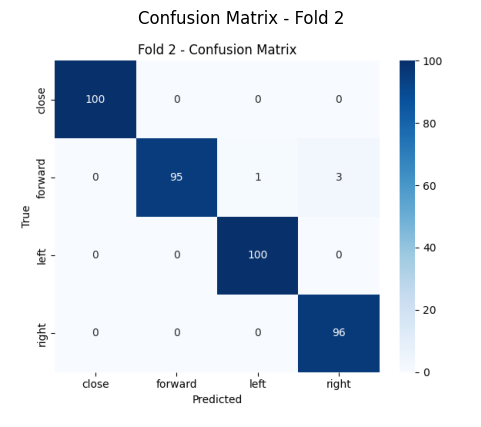


🔍 Fold 8 - Accuracy: 0.9192 | F1: 0.9189


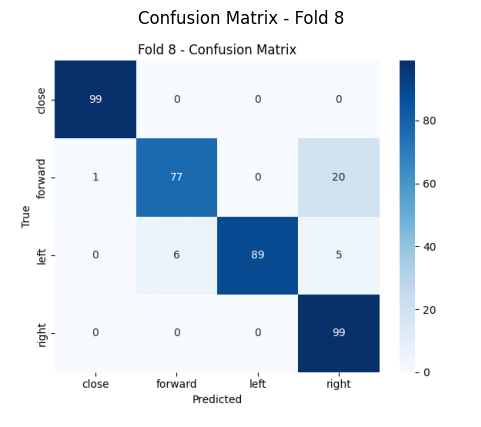


🔍 Fold 3 - Accuracy: 0.9125 | F1: 0.9096


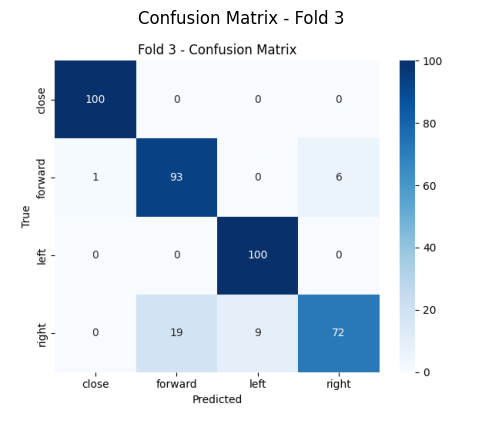

In [3]:
import matplotlib.image as mpimg

# Get indices of top 3 folds by accuracy
top3_indices = np.argsort(fold_accuracies)[-3:][::-1]

for i in top3_indices:
    fold_num = i + 1
    print(f"\n🔍 Fold {fold_num} - Accuracy: {fold_accuracies[i]:.4f} | F1: {fold_f1s[i]:.4f}")
    
    img = mpimg.imread(f'confusion_matrix_fold_{fold_num}.png')
    plt.figure(figsize=(6, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Confusion Matrix - Fold {fold_num}')
    plt.show()


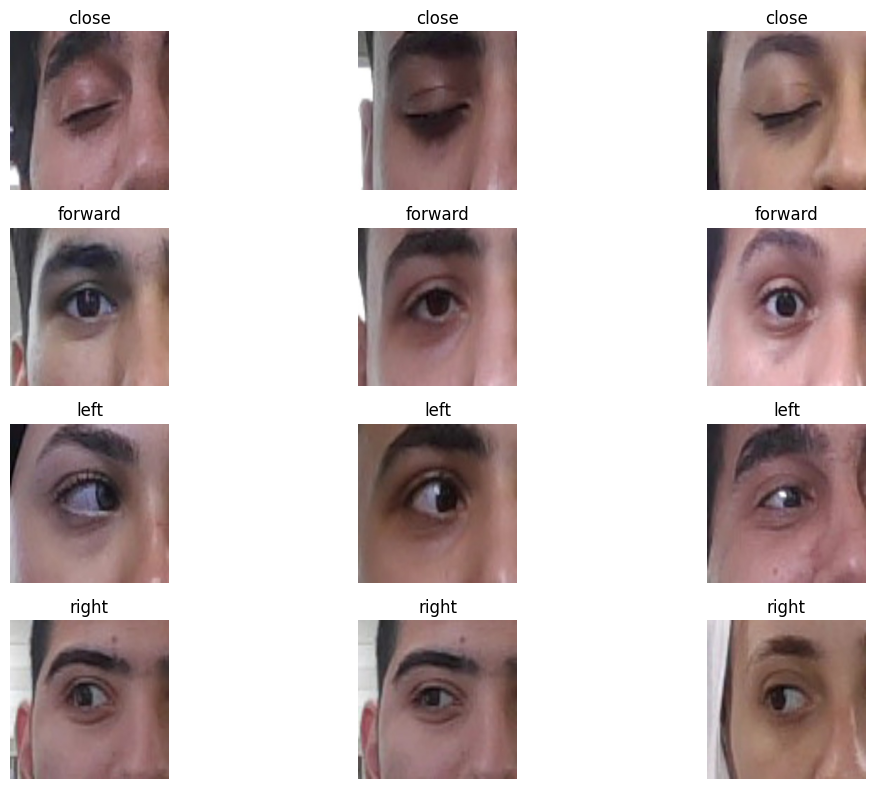

In [4]:
import matplotlib.image as mpimg

sample_dir = os.path.join(FOLD_PATH, "fold_1", "train")
num_samples_per_class = 3

plt.figure(figsize=(12, 8))
i = 1
for class_name in class_names:
    class_dir = os.path.join(sample_dir, class_name)
    sample_images = random.sample(os.listdir(class_dir), num_samples_per_class)
    
    for img_file in sample_images:
        img_path = os.path.join(class_dir, img_file)
        img = mpimg.imread(img_path)
        
        plt.subplot(len(class_names), num_samples_per_class, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
        i += 1

plt.tight_layout()
plt.show()


In [7]:
sample_dir = os.path.join(FOLD_PATH, "fold_1", "train")
num_samples_per_class = 3

plt.figure(figsize=(12, 8))
i = 1
for class_name in class_names:
    class_dir = os.path.join(sample_dir, class_name)
    sample_images = random.sample(os.listdir(class_dir), num_samples_per_class)

    for img_file in sample_images:
        img_path = os.path.join(class_dir, img_file)
        img = mpimg.imread(img_path)

        plt.subplot(len(class_names), num_samples_per_class, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
        i += 1

plt.tight_layout()
plt.savefig('sample_dataset_visualization.png')
plt.close()


In [5]:
from sklearn.metrics import multilabel_confusion_matrix

# Pick best fold by accuracy
best_fold = np.argmax(fold_accuracies) + 1
print(f"🔍 Best Fold: {best_fold}")

# Reload test set
test_data = val_aug.flow_from_directory(
    os.path.join(FOLD_PATH, f"fold_{best_fold}", "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=class_names
)

# Load best model
best_model_path = f"model_fold_{best_fold}_fine_tuned.keras"
model = tf.keras.models.load_model(best_model_path)

# Predict again
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

# Get TP, TN, FP, FN
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Display per-class TP/TN
for i, label in enumerate(class_names):
    tn, fp, fn, tp = mcm[i].ravel()
    print(f"\n🔷 Class: {label}")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")


🔍 Best Fold: 2
Found 395 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step

🔷 Class: close
TP: 100, TN: 295, FP: 0, FN: 0

🔷 Class: forward
TP: 72, TN: 296, FP: 0, FN: 27

🔷 Class: left
TP: 97, TN: 290, FP: 5, FN: 3

🔷 Class: right
TP: 96, TN: 274, FP: 25, FN: 0


In [10]:
import tensorflow as tf
import glob
import os
import ast

# === Load fold accuracies from summary file
summary_file = "kfold_results_summary.txt"
if not os.path.exists(summary_file):
    print("❌ kfold_results_summary.txt not found. Please run evaluation first.")
    exit()

with open(summary_file, "r") as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith("Per-fold Accuracies"):
            accuracy_line = line.split(":")[1].strip()
            fold_accuracies = ast.literal_eval(accuracy_line)

# === Get top 3 folds by accuracy
top3_indices = sorted(range(len(fold_accuracies)), key=lambda i: fold_accuracies[i], reverse=True)[:3]
top3_folds = [i + 1 for i in top3_indices]  # fold numbers are 1-indexed

print("📈 Top 3 folds based on accuracy:", top3_folds)

# === Convert only the top 3 fine-tuned models
for fold_num in top3_folds:
    keras_model_path = f"model_fold_{fold_num}_fine_tuned.keras"
    tflite_model_path = keras_model_path.replace(".keras", "_float16.tflite")

    if not os.path.exists(keras_model_path):
        print(f"❌ Model not found: {keras_model_path}")
        continue

    print(f"\n[+] Exporting {keras_model_path} → {tflite_model_path}")
    
    # Load and convert
    model = tf.keras.models.load_model(keras_model_path)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    tflite_model = converter.convert()

    # Save
    with open(tflite_model_path, "wb") as f:
        f.write(tflite_model)

    print(f"✅ Saved: {tflite_model_path}")

print("\n🎉 Best 3 fine-tuned models exported to float16 TFLite format!")


📈 Top 3 folds based on accuracy: [2, 8, 3]

[+] Exporting model_fold_2_fine_tuned.keras → model_fold_2_fine_tuned_float16.tflite
Saved artifact at '/tmp/tmpk0syqrd7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136484930662480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480969423760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480950435088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136484924943696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480950434320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480950426640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480420689104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480950699216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480950704208: TensorS

W0000 00:00:1751386938.776349      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751386938.776398      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1751386938.919233      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


✅ Saved: model_fold_2_fine_tuned_float16.tflite

[+] Exporting model_fold_8_fine_tuned.keras → model_fold_8_fine_tuned_float16.tflite
Saved artifact at '/tmp/tmp22f_abgk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136474662743952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136474662747792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136474662747600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136474662747984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136474662743760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136474662744144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136474662745680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136474662745296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136474662745488: Te

W0000 00:00:1751386962.876622      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751386962.876652      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


✅ Saved: model_fold_8_fine_tuned_float16.tflite

[+] Exporting model_fold_3_fine_tuned.keras → model_fold_3_fine_tuned_float16.tflite
Saved artifact at '/tmp/tmp8zmw5pmu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136480436518160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480436516816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480436516432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480436516624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480436517968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480436518352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480436514896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480436514512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136480436514704: Te

W0000 00:00:1751386988.474410      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751386988.474440      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
